In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, types
import pyspark.sql.functions as F
from  pyspark.sql.functions import col


spark = (
    SparkSession.builder.config("spark.sql.debug.maxToStringFields", 100)
    .appName("reviews")
    .getOrCreate()
)

# data_filepath = "../data/cleaned_steam_reviews/game_id={578080,271590,359550,105600,4000,252490,252950,218620,945360,292030}"
# data_filepath = "../data/cleaned_steam_reviews/game_id={294100,304390,812140,306130,391220,221380,262060,1289310,646570,552520}"
data_filepath = "../data/cleaned_steam_reviews"
steam_games_filepath = "../data/cleaned_steam_games"

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/28 19:48:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/28 19:48:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/28 19:48:15 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/11/28 19:48:15 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
steam_reviews = spark.read.parquet(data_filepath)
steam_games = spark.read.parquet(steam_games_filepath)

In [3]:
tags_map = steam_games.select("game_id", F.explode_outer(F.split(col("popular_tags"),",")).alias("tags")) \
                        .drop("popular_tags") \
                        .where(col("tags") != F.lit("null"))

# ['2D', 'Action', 'Adventure', 'Atmospheric', 'Casual', 'Difficult', 'Early Access', 'Fantasy', 'Free to Play','Great Soundtrack',
# 'Indie', 'Multiplayer', 'Puzzle', 'RPG', 'Simulation', 'Singleplayer', 'Story Rich', 'Strategy', 'VR', 'Violent']
top_20_tags = tags_map.groupBy("tags") \
                        .count() \
                        .orderBy("count", ascending=False) \
                        .limit(20) \
                        .select("tags") \
                        .distinct() \
                        .orderBy("tags")

top_20_tags_names = map(lambda row: row.asDict(), top_20_tags.collect())
top_20_tags_names = [row["tags"] for row in top_20_tags_names]

tags = tags_map.join(top_20_tags, "tags").select("game_id", tags_map["tags"]).distinct()

tags_pos = {}
for pos, tag in enumerate(top_20_tags_names):
    tags_pos[tag] = pos

In [4]:
apps_by_author = steam_reviews.select("app_id", "author_steamid") \
                                .where((col("author_steamid") != F.lit("null")) & (F.length(col("author_steamid")) == 17) & (col("author_steamid").rlike("^[0-9]+$"))) \
                                .distinct()

steam_by_author_tags = apps_by_author.join(tags, apps_by_author["app_id"] == tags["game_id"]).drop("game_id")

steam_tags = steam_games.select("game_id", F.split(col("popular_tags"),",").alias("encode_tags"))
steam_by_author_tags = steam_by_author_tags.join(steam_tags, steam_by_author_tags["app_id"] == steam_tags["game_id"]).drop("game_id")


In [5]:
# encode = [('2D', 0), ('Action', 1), ('Adventure', 2), ('Atmospheric', 3), ('Casual', 4), ('Difficult', 5), \
#           ('Early Access', 6), ('Fantasy', 7), ('Free to Play', 8), ('Great Soundtrack', 9), ('Indie', 10), \
#           ('Multiplayer', 11), ('Puzzle', 12), ('RPG', 13), ('Simulation', 14), ('Singleplayer', 15), \
#           ('Story Rich', 16), ('Strategy', 17), ('VR', 18), ('Great Violent', 19)]
tags_onehot = steam_by_author_tags

for tag in top_20_tags_names:
    tags_onehot = tags_onehot.withColumn(tag, F.array_contains(col("encode_tags"), tag).cast("int"))
tags_onehot = tags_onehot.drop("encode_tags")

In [6]:
tags_correlation = tags_onehot.groupBy("tags").agg(F.count("*").alias("count"), \
                                                    F.avg("2D").alias("2D"), \
                                                    F.avg("Action").alias("Action"), \
                                                    F.avg("Adventure").alias("Adventure"), \
                                                    F.avg("Atmospheric").alias("Atmospheric"), \
                                                    F.avg("Casual").alias("Casual"), \
                                                    F.avg("Difficult").alias("Difficult"), \
                                                    F.avg("Early Access").alias("Early Access"), \
                                                    F.avg("Fantasy").alias("Fantasy"), \
                                                    F.avg("Free to Play").alias("Free to Play"), \
                                                    F.avg("Great Soundtrack").alias("Great Soundtrack"), \
                                                    F.avg("Indie").alias("Indie"), \
                                                    F.avg("Multiplayer").alias("Multiplayer"), \
                                                    F.avg("Puzzle").alias("Puzzle"), \
                                                    F.avg("RPG").alias("RPG"), \
                                                    F.avg("Simulation").alias("Simulation"), \
                                                    F.avg("Singleplayer").alias("Singleplayer"), \
                                                    F.avg("Story Rich").alias("Story Rich"), \
                                                    F.avg("Strategy").alias("Strategy"), \
                                                    F.avg("VR").alias("VR"), \
                                                    F.avg("Violent").alias("Violent") \
                                                   )

In [7]:
# tags_correlation.show()

In [7]:
tags_correlation_dict = list(map(lambda row: row.asDict(), tags_correlation.collect()))

matrix = [ [0] * len(top_20_tags_names) for _ in range(len(top_20_tags_names)) ]

for data in tags_correlation_dict:
    tag = data["tags"]
    for matching_tag in top_20_tags_names:
        matrix[tags_pos[tag]][tags_pos[matching_tag]] = data[matching_tag]


# for i in range(len(matrix)):
#     for j in range(len(matrix[0])):
#         matrix[i][j] = round(matrix[i][j] * 100, 2)

23/11/28 19:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/28 19:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/28 19:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/28 19:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/28 19:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/28 19:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/28 19:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/28 19:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/28 19:48:50 WARN RowBasedKeyValueBatch: Calling spill() on

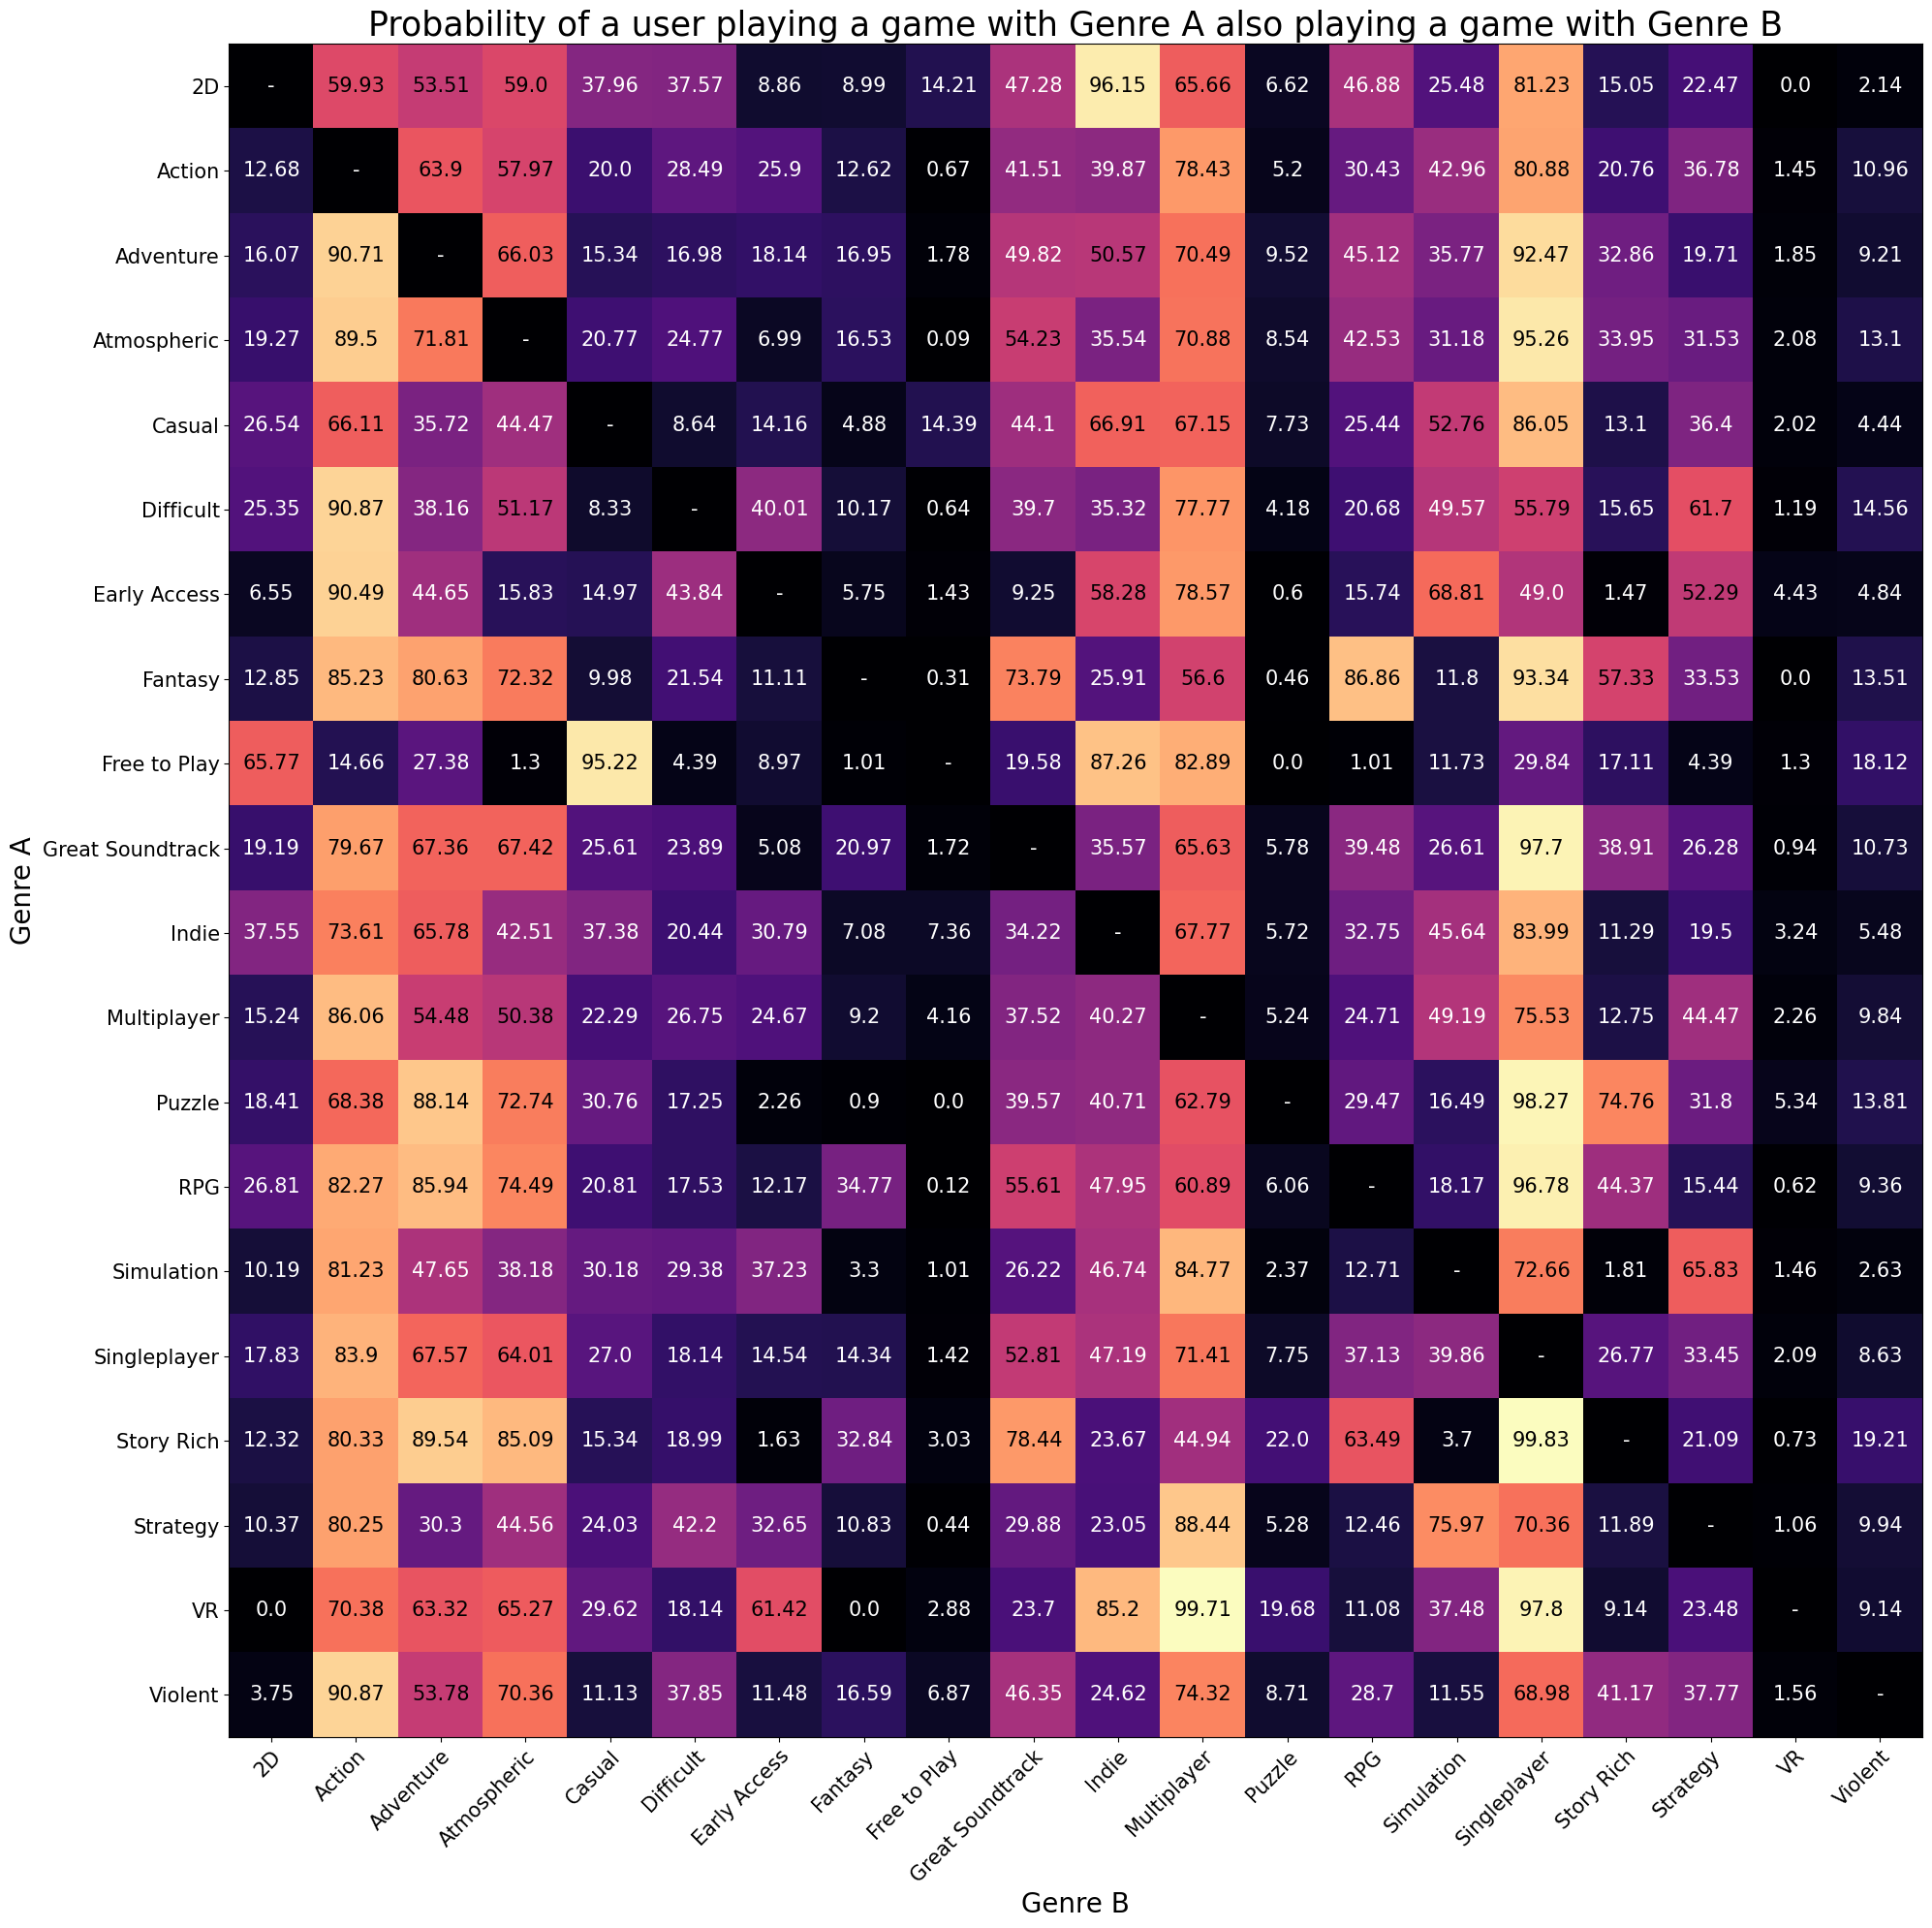

In [9]:
H = len(top_20_tags_names)
W = len(top_20_tags_names)

for i in range(H):
    matrix[i][i] = 0

from matplotlib.pyplot import plot
import numpy as np

matrix_np = np.array(matrix)

fig, ax = plt.subplots(figsize=(30, 20))
im = ax.imshow(matrix_np, cmap="magma")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(top_20_tags_names)), labels=top_20_tags_names)
ax.set_yticks(np.arange(len(top_20_tags_names)), labels=top_20_tags_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", fontsize=15)
# change yticklabels fontsize to 15
plt.setp(ax.get_yticklabels(), fontsize=15)

# Loop over data dimensions and create text annotations.
for i in range(len(top_20_tags_names)):
    for j in range(len(top_20_tags_names)):
        if (matrix_np[i, j] > 50):
            color = "k"
        else:
            color = "w"
        if (i == j):
            value = "-"
        else:
            value = matrix_np[i, j]
        text = ax.text(j, i, value,
                       ha="center", va="center", color=color, fontsize=15)

ax.set_title("Probability of a user playing a game with Genre A also playing a game with Genre B", fontsize=25)
ax.set_xlabel("Genre B", fontsize=20)
ax.set_ylabel("Genre A", fontsize=20)
fig.tight_layout()
plt.show()

In [9]:
print(top_20_tags_names)

['2D', 'Action', 'Adventure', 'Atmospheric', 'Casual', 'Difficult', 'Early Access', 'Fantasy', 'Free to Play', 'Great Soundtrack', 'Indie', 'Multiplayer', 'Puzzle', 'RPG', 'Simulation', 'Singleplayer', 'Story Rich', 'Strategy', 'VR', 'Violent']


In [18]:
cluster_num = 8

from sklearn.cluster import AgglomerativeClustering


data_matrix = matrix.copy()
for i in range(len(data_matrix)):
    for j in range(len(data_matrix[0])):
        data_matrix[i][j] = 1 - data_matrix[i][j]

model = AgglomerativeClustering(
  affinity='precomputed',
  n_clusters=cluster_num,
  linkage='complete'
).fit(data_matrix)

print(model.labels_)

[0 3 3 3 0 2 2 1 5 0 0 5 7 1 2 7 1 2 4 6]


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [19]:
for i in range(cluster_num):
    print("Cluster", i, ":")
    for j in range(len(model.labels_)):
        if (model.labels_[j] == i):
            print("   ", top_20_tags_names[j])
    print()


Cluster 0 :
    2D
    Casual
    Great Soundtrack
    Indie

Cluster 1 :
    Fantasy
    RPG
    Story Rich

Cluster 2 :
    Difficult
    Early Access
    Simulation
    Strategy

Cluster 3 :
    Action
    Adventure
    Atmospheric

Cluster 4 :
    VR

Cluster 5 :
    Free to Play
    Multiplayer

Cluster 6 :
    Violent

Cluster 7 :
    Puzzle
    Singleplayer



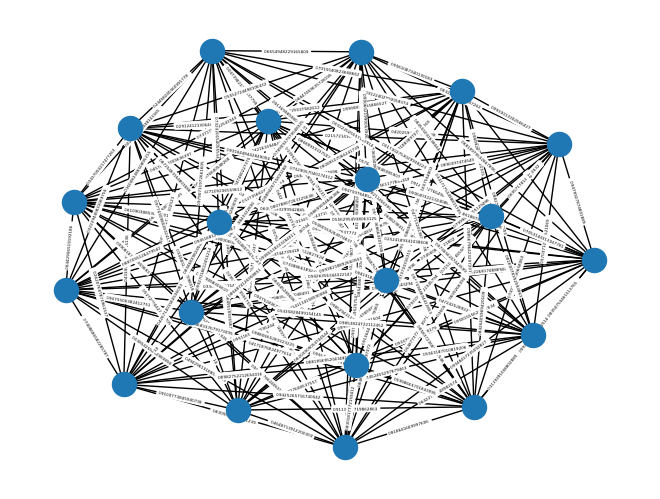

In [39]:
import networkx as nx   

# Create a graph
G = nx.Graph()

# distances
D = data_matrix.copy()

labels = {}
for n in range(len(D)):
    for m in range(len(D)-(n+1)):
        G.add_edge(n,n+m+1)
        labels[ (n,n+m+1) ] = str(D[n][n+m+1])

pos=nx.spring_layout(G)

nx.draw(G, pos)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=3)

import pylab as plt
plt.show()

In [37]:
for i, genre_name in enumerate(genre_names):
    print(genre_name, model.labels_[i])

2D 1
Action 1
Adventure 1
Atmospheric 1
Casual 1
Difficult 1
Early Access 1
Fantasy 3
Free to Play 2
Great Soundtrack 1
Indie 1
Multiplayer 2
Puzzle 0
RPG 3
Simulation 1
Singleplayer 0
Story Rich 3
Strategy 1
VR 0
Violent 2


In [22]:
print(matrix)

[[1.0, 0.5993042168327004, 0.5351286087799697, 0.5900344428540096, 0.37960909452954555, 0.37572723914624434, 0.08863082801371365, 0.08992261540592643, 0.14210815662191645, 0.4727999572891295, 0.9614574074501611, 0.6565977472901684, 0.06620437440118206, 0.46880952106107654, 0.2547544702120537, 0.8123409164367591, 0.1504800644126101, 0.2246894804280322, 0.0, 0.02138465467684032], [0.1267721684640736, 1.0, 0.6390005639073361, 0.5797407705003972, 0.20001777948705035, 0.2848957534496402, 0.25895426093419377, 0.12620780328714482, 0.006698669743357301, 0.4151053911525304, 0.3986586025628406, 0.78427858395924, 0.052007212519811157, 0.30428218564073684, 0.42962871394789315, 0.8087759700694163, 0.20764388221585822, 0.3677615167962738, 0.01451813393218919, 0.10960252545022926], [0.16069155717895972, 0.9071091454055242, 1.0, 0.6602800372198626, 0.15342512644029277, 0.16981822278405873, 0.18135833000239393, 0.16949390302687609, 0.01776262696836853, 0.4982478717192955, 0.5057038681142983, 0.70486782

In [24]:
print(data_matrix)

[[0.0, 0.4006957831672996, 0.4648713912200303, 0.40996555714599037, 0.6203909054704544, 0.6242727608537557, 0.9113691719862863, 0.9100773845940736, 0.8578918433780836, 0.5272000427108705, 0.03854259254983894, 0.3434022527098316, 0.9337956255988179, 0.5311904789389235, 0.7452455297879463, 0.1876590835632409, 0.8495199355873899, 0.7753105195719678, 1.0, 0.9786153453231596], [0.8732278315359264, 0.0, 0.36099943609266394, 0.4202592294996028, 0.7999822205129496, 0.7151042465503599, 0.7410457390658063, 0.8737921967128552, 0.9933013302566427, 0.5848946088474696, 0.6013413974371594, 0.21572141604076, 0.9479927874801889, 0.6957178143592632, 0.5703712860521069, 0.19122402993058374, 0.7923561177841418, 0.6322384832037262, 0.9854818660678109, 0.8903974745497707], [0.8393084428210402, 0.09289085459447577, 0.0, 0.3397199627801374, 0.8465748735597072, 0.8301817772159412, 0.818641669997606, 0.8305060969731239, 0.9822373730316315, 0.5017521282807045, 0.49429613188570165, 0.295132170591759, 0.9048417235

In [30]:
print(genre_names)

['2D', 'Action', 'Adventure', 'Atmospheric', 'Casual', 'Difficult', 'Early Access', 'Fantasy', 'Free to Play', 'Great Soundtrack', 'Indie', 'Multiplayer', 'Puzzle', 'RPG', 'Simulation', 'Singleplayer', 'Story Rich', 'Strategy', 'VR', 'Violent']


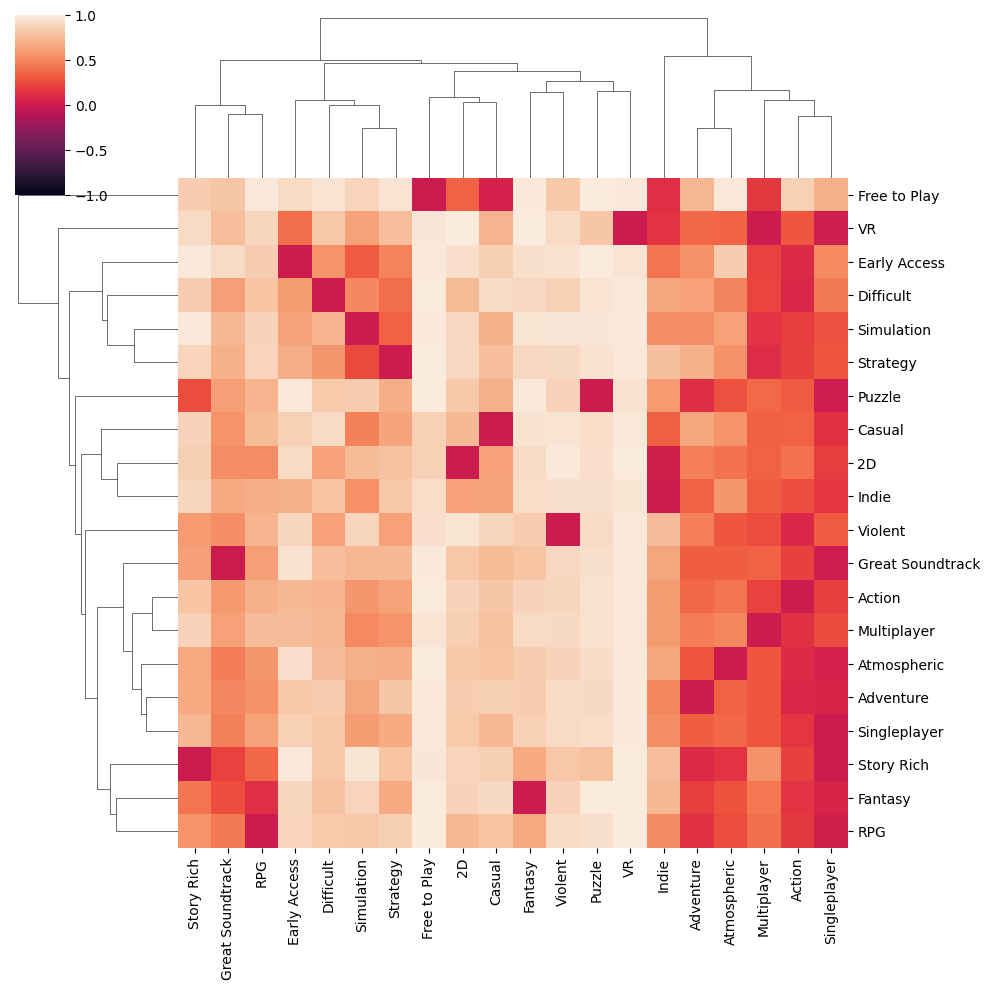

In [42]:
import numpy as np
import seaborn as sns

# Data simulation
np.random.seed(2)
data = np.random.rand(6, 6)

# change the sns ticks label to genre names
genre_names = top_20_tags_names
sns.clustermap(data_matrix,
               vmin = -1, vmax = 1, xticklabels = genre_names, yticklabels = genre_names)

